In [1]:
!pip install flax

     |████████████████████████████████| 153kB 4.8MB/s 


In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import flax 
import flax.nn as nn

In [3]:
def P_local_matvec(k, K, w1, w2, x):
    x1 = x.reshape((2**k, -1))
    tmp = jnp.zeros(x1.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[:-1, :], x1[1:, :])
    res = (x1@w1) + (tmp@w2)
    return res.flatten()


def P_local_matvec_t(k, K, w1, w2, x):
    x1 = x.reshape((2**k, -1))     #Can we make a 2D version
    tmp = jnp.zeros(x1.shape)
    tmp = jax.ops.index_update(tmp, jax.ops.index[1:, :], x1[:-1, :])
    res = x1@w1.T + (tmp@w2.T)

    return res.flatten()


class Projector_direct(nn.Module):
    def apply(self, x, k, K):
        s = (K-k)
        sp = (2**s, 1)
        w1 = self.param('w1', sp, nn.initializers.lecun_normal())
        w2 = self.param('w2', sp, nn.initializers.lecun_normal())
        x1 = x.reshape((2**k, -1))
        y = P_local_matvec(k, K, w1, w2, x1)
        z = P_local_matvec_t(k, K, w1, w2, y)
        z = z.reshape(x.shape)
        return z


In [4]:
def get_init_params(k, K):
    s = (K-k)
    xi = jnp.ones(2**s)
    eta = (jnp.arange(2**s) + 1)*1.0*(2**(-s))
    xi = jnp.reshape(xi, (-1, 1))
    eta = jnp.reshape(eta, (-1, 1))
    w1 = eta
    w2 = xi - eta
    w1 = w1*(2**(-s/2))
    w2 = w2*(2**(-s/2))
    return w1, w2

In [5]:
class BPX(nn.Module):
    def apply(self, x, K):
        y = jnp.zeros(x.shape)
        for k in range(K+1):
            scale = self.param('scale_{0:d}'.format(k), (1, ), nn.initializers.ones)
            y = y + 0.5*(scale + abs(scale))*Projector_direct(x, k, K)
        return y


def init_BPX(K, model):
    params = {}
    for k in range(K+1):
        name = 'Projector_direct_{0:d}'.format(k)
        scale_name = 'scale_{0:d}'.format(k)
        w1, w2 = get_init_params(k, K)
        loc_params = {'w1': w1, 'w2': w2}
        params[name] = loc_params
        params[scale_name] = jnp.reshape(2**(-k), (1, ))*0.05
        #params[scale_name] = jnp.reshape(2**(-k), (1, ))*1e-2

    return model.replace(params=params)

In [6]:
def loss(dpx_model, mat, x):
    sz = x.shape
    y = x
    dpx_model_batch = jax.vmap(dpx_model, 1, 1) 
    z = y
    for i in range(3):
        z = y.reshape(y.shape) 
        By = dpx_model_batch(z) 
        By = jnp.reshape(By, y.shape)
        By = mat@By 
        By = dpx_model_batch(By) 
        
        y = y - By 
    return jnp.mean(jnp.einsum('ib, ib->b', y, y))

In [15]:
def power_method_update(dpx_model, mat, x):
    # dpx_model_batch = jax.vmap(dpx_model, 1, 1) 
    y = x
    # z = y
    # BY_0 = dpx_model_batch(z)
    # BY_0 = jnp.reshape(BY_0, y.shape)
    # BY_0 = mat@BY_0
    # BY_0 = dpx_model_batch(BY_0)
    # BY_0 = z - BY_0
    # # print('A shape ', jnp.expand_dims(BY_0[:, 0], axis=1).shape)
    # BY_0_v = jnp.expand_dims(BY_0[:, 0], axis=1)
    dpx_model_batch_2 = jax.vmap(dpx_model, 1, 1) 
    
    for i in range(10):
        d = y.reshape(y.shape) 
        # print('d shape', d.shape)
        By = dpx_model_batch_2(d) 
        By = jnp.reshape(By, y.shape)
        By = mat@By 
        By = dpx_model_batch_2(By) 
        y = y - By 
        # print(y == d)
    # print('y shape', jnp.expand_dims(y[:, 0], axis=1).shape)
    y_v = jnp.expand_dims(y[:, 0], axis=1)
    d_v = jnp.expand_dims(d[:, 0], axis=1)
    eigen_v = (y_v.T @ d_v) /(d_v.T @ d_v) 
    # eigen_v = (BY_0.T @ y) /(y.T @ y) 
    return eigen_v[0][0]

In [16]:
rng = jax.random.PRNGKey(2010)
rng, key = jax.random.split(rng)

K = 8
B_cur = BPX.partial(K=K)
n = 2**K
x0 = jnp.ones(n)
_, init_params = B_cur.init(key, x0)
init_model = nn.Model(B_cur, init_params)
true_BPX = init_BPX(K, init_model)

# K = 5
# n = 2**K 
z = jnp.diag(jnp.ones(n-1), -1)
e = jnp.eye(n)
lp = 2*e - z - z.T
lp = lp*(n+1)**2

c = 1e2 # convection coefficient

mat = lp
model = true_BPX

In [17]:
n = 2**K
batch_size = 512
x_batch = jax.random.normal(key, (n, batch_size))
x_batch = x_batch/jnp.linalg.norm(x_batch, axis=0)[None, :]

mat = e + 1e-2*lp

loss(model, mat, x_batch)

DeviceArray(0.99867415, dtype=float32)

In [18]:
power_method_update(model, mat, x_batch)

DeviceArray(0.9998306, dtype=float32)

In [19]:
@jax.jit
def update(opt, x):
    eig = jnp.mean(jnp.mean(power_method_update(opt.target, mat, x)))
    l1, grad1 = jax.value_and_grad(loss)(opt.target, mat, x)
    return  eig, l1, opt.apply_gradient(grad1)

In [20]:
n

256

In [21]:
opt = flax.optim.Adam(1e-5).create(model)

In [22]:
import matplotlib.pyplot as plt
loss_array = []
eigen_array = []

In [23]:
from IPython import display
import numpy as np
import matplotlib.pyplot as plt


def plot(loss_history, eig_history, iter_number, clear_output=True):
    if clear_output:
        display.clear_output(wait=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.plot(loss_history, label = 'loss_history')
    ax.plot(eig_history, label = 'eig_history')
    ax.set_title('loss and eig decay')
    ax.set_xlabel('# iteration processed')
    # ax.set_ylabel('loss value')
    ax.legend()

    plt.show()  



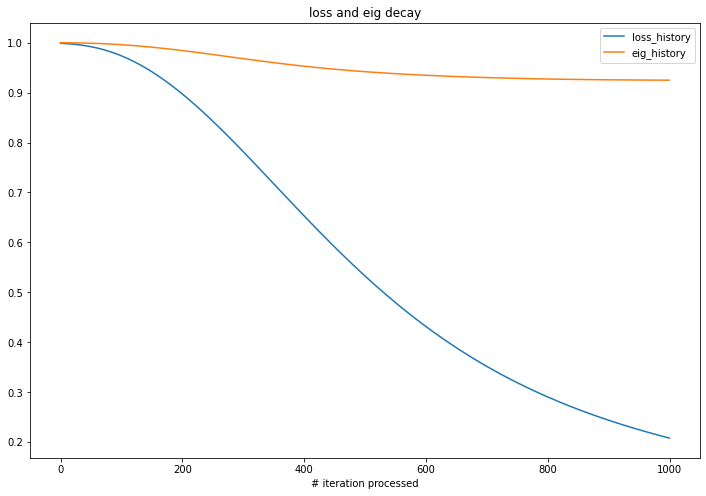

100%|██████████| 1000/1000 [17:02<00:00,  1.02s/it]


In [24]:
from tqdm import tqdm

for i in tqdm(range(1000)):
    eig_val, loss_val, opt = update(opt, x_batch)
    loss_array.append(loss_val)
    eigen_array.append(eig_val)
    plot(loss_array, eigen_array, i)
   

In [ ]:
n = 2**K
batch_size = 1
x_batch = jax.random.normal(key, (n, batch_size))